In [1]:
import numpy as np
import matplotlib.pyplot as plt
import okada_wrapper
import matplotlib.tri as tri
import sys
sys.path.append('../common')

In [2]:
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
font_size = 12
rc('font', size=font_size)
rc('axes', titlesize=font_size)
%config InlineBackend.figure_format = 'retina'

In [3]:
pts, tris = np.load('planar_wenchuan.npy')

In [4]:
pts[pts[:,2] > 0,2] = 0

In [5]:
# pts are expected to be in the order:
# idx 0 = lower left
# idx 1 = upper left
# idx 2 = upper right
# idx 3 = lower right
def xyrot_mat(theta):
    return np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta), np.cos(theta),0],[0,0,1]])

def rotate_to_xaxis(quad):
    strike = quad[2] - quad[1]
    strike /= np.linalg.norm(strike)
    theta = -np.arccos(strike[0])
    R = xyrot_mat(theta)
    Rdstrike = R.dot(strike)
    np.testing.assert_almost_equal(Rdstrike, [1.0, 0.0, 0.0])
    qax = R.dot(quad.T).T
    return qax, R

def rectify_xaxis_quad(qax, R):
    rect = np.array([
        [qax[1,0], qax[0,1], qax[0,2]],
        qax[1], qax[2],
        [qax[2,0], qax[0,1], qax[0,2]]
    ])
    orig_rect = R.T.dot(rect.T).T.copy()
    return rect, orig_rect

def get_okada_params(rect):
    x_L = (rect[2,0] - rect[1,0]) / 2.0
    fcenter = np.mean(rect, axis = 0)
    upper_edge_mid_pt = np.mean(rect[[1,2]], axis = 0)
    dip_v = fcenter - upper_edge_mid_pt
    dip_L = np.linalg.norm(dip_v)
    dip = np.rad2deg(np.arccos((dip_v / np.linalg.norm(dip_v)).dot([0,1,0])))
    return (-x_L, x_L), (-dip_L, dip_L), -dip, fcenter

# Assumes the rectangle has already been "rectified" (it's actually a rectangle, not a general quadrilateral)
def run_okada(rect, sm, pr, obs_pts):
    lam = 2 * sm * pr / (1 - 2 * pr)
    alpha = (lam + sm) / (lam + 2 * sm)
    qax, R = rotate_to_xaxis(rect)
    rect, orig_rect = rectify_xaxis_quad(qax, R)
    x_R, dip_R, dip, fcenter = get_okada_params(rect)

    rot_obs_pts = R.dot(obs_pts.T).T
    rot_obs_pts[:,:2] -= fcenter[:2]
    
#     plt.plot(rot_obs_pts[:,0], rot_obs_pts[:,1], '.')
#     surf_y = np.cos(np.deg2rad(dip)) * dip_R[0]
#     plt.plot(x_R, [surf_y,surf_y], 'k-')
#     plt.plot(rect[[1,2],0] - fcenter[0], rect[[1,2],1] - fcenter[1], 'k-')
#     plt.show()
    
    rot_u = np.empty((rot_obs_pts.shape[0], 3))
    for i in range(rot_obs_pts.shape[0]):
        success, rot_u[i,:], _ = okada_wrapper.dc3dwrapper(
            alpha, [rot_obs_pts[i,0], rot_obs_pts[i,1], 0.0],
            -fcenter[2], dip, x_R, dip_R, [0.0, -1.0, 0.0]
        )
        assert(success == 0)
    u = R.T.dot(rot_u.T).T
    return u

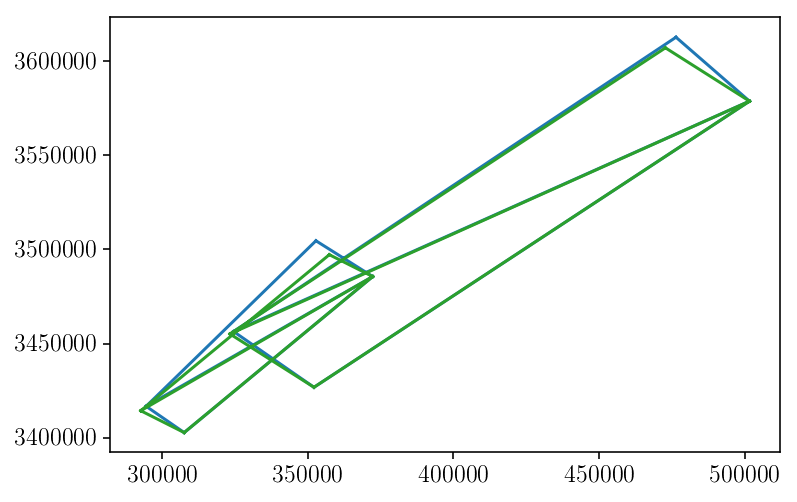

In [6]:
rect1 = rectify_xaxis_quad(*rotate_to_xaxis(pts[:4]))[1]
rect2 = rectify_xaxis_quad(*rotate_to_xaxis(pts[4:]))[1]
new_pts = pts.copy()
new_pts[:4] = rect1
new_pts[4:] = rect2
plt.triplot(pts[:,0], pts[:,1], tris)
plt.triplot(new_pts[:,0], new_pts[:,1], tris)
plt.show()

In [7]:
view_center = np.array([394461.32015672, 3501242.64776442, -11163.61738238])
vW = 110810.9763772876
nx = 300 # This is a really high point density that is nice for plotting, but runs slowish.
xs = np.linspace(view_center[0] - vW, view_center[0] + vW, nx)
ys = np.linspace(view_center[1] - vW, view_center[1] + vW, nx)
X, Y = np.meshgrid(xs, ys)
obs_pts = np.array([X.flatten(),Y.flatten(), np.zeros(X.size)]).T.copy()

In [8]:
sm = 1.0
pr = 0.25
u = np.sum([run_okada(r, sm, pr, obs_pts) for r in [rect1, rect2]], axis = 0)

In [9]:
triang = tri.Triangulation(obs_pts[:,0], obs_pts[:,1])

In [10]:
def remove_unused_pts(m):
    referenced_pts = np.unique(m[1])
    new_pts = m[0][referenced_pts,:]
    new_indices = np.empty(m[0].shape[0], dtype = np.int64)
    new_indices[referenced_pts] = np.arange(referenced_pts.shape[0])
    new_tris = new_indices[m[1]]
    return (new_pts, new_tris)

def get_surf_fault_edges(surf_tris, fault_tris):
    surf_verts = np.unique(surf_tris)
    surf_fault_edges = []
    for i, t in enumerate(fault_tris):
        in_surf = []
        for d in range(3):
            if t[d] in surf_verts:
                in_surf.append((i, d))
        if len(in_surf) == 2:
            surf_fault_edges.append(in_surf)
    return surf_fault_edges

soln, m_pts, m_tris, fault_start_idx, side = np.load('wenchuan320k_plotting_data.npy')
surf_fault_edges = get_surf_fault_edges(m_tris[:fault_start_idx], m_tris[fault_start_idx:])

Below here is the actual plotting code. Above is code that loads and generates the data for the plots.

*

*

*

*

*


*


*


*

In [11]:
d = 2 # plot z component, set d = 0 for x, d = 1 for y
vmin = -0.25
vmax = 1.0
# vmin = np.min(u[:,d])
# vmax = np.max(u[:,d])
levels = np.linspace(vmin, vmax, 16)
cmap = 'PuOr_r'

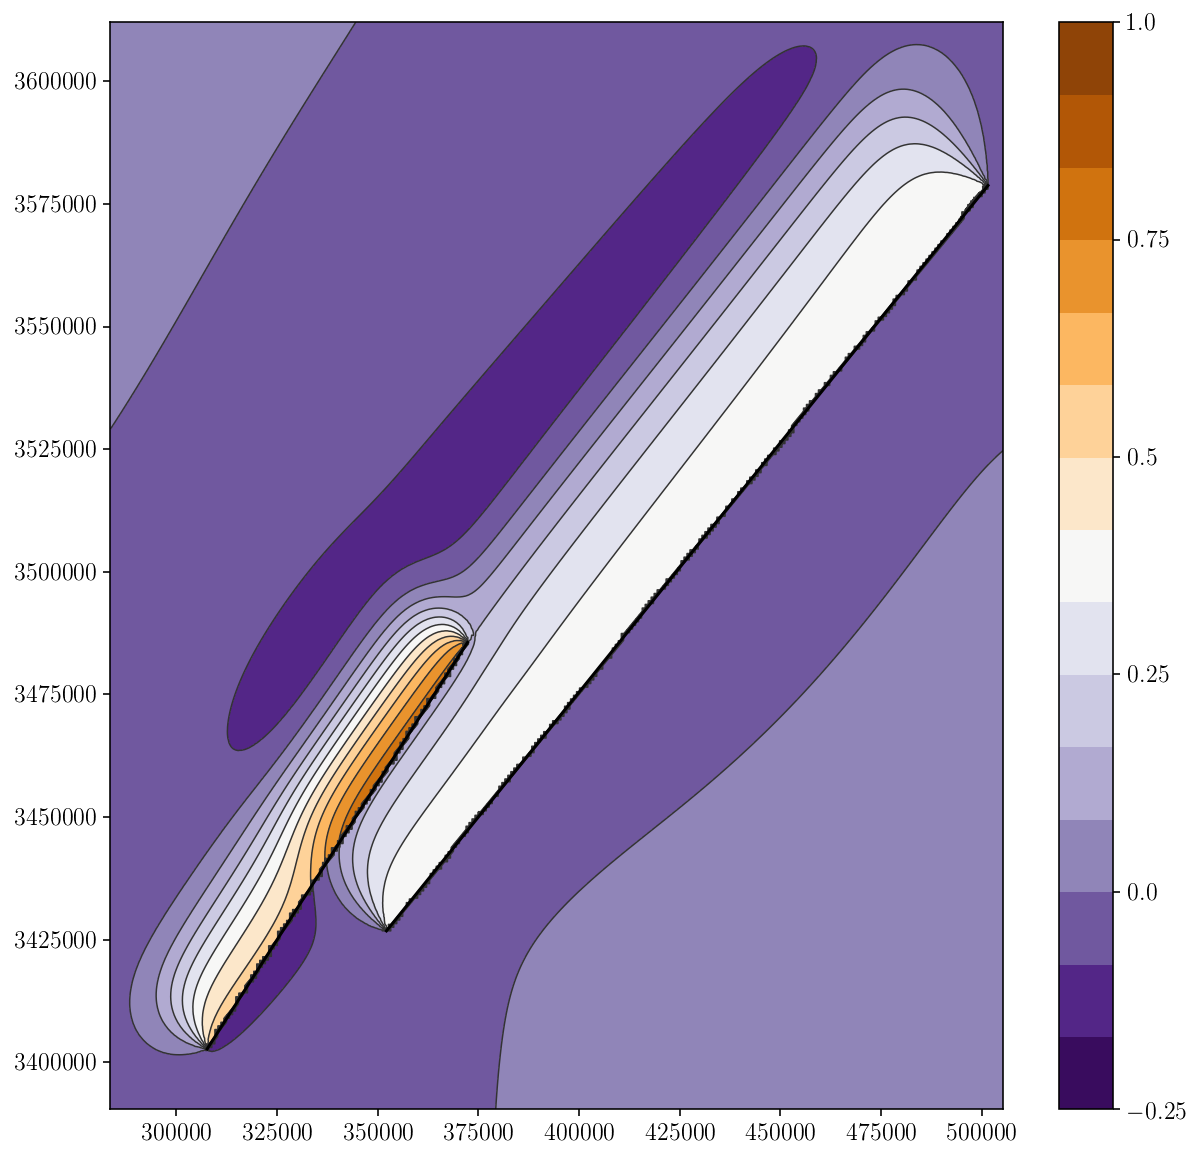

In [12]:
vals = u[:,d]
plt.figure(figsize = (10,10))
cntf = plt.tricontourf(triang, vals, cmap = cmap, levels = levels)
plt.tricontour(
    triang, vals, levels = levels, 
    colors = '#333333', linestyles = 'solid', linewidths = 0.75
)
for r in [rect1, rect2]:
    plt.plot(r[1:3,0], r[1:3,1], 'k-')
cbar = plt.colorbar(cntf)
cbar.set_ticks(levels[::3])
cbar.set_ticklabels(['$' + str(l) + '$' for l in levels[::3]])
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.savefig('okada.pdf')
plt.show()

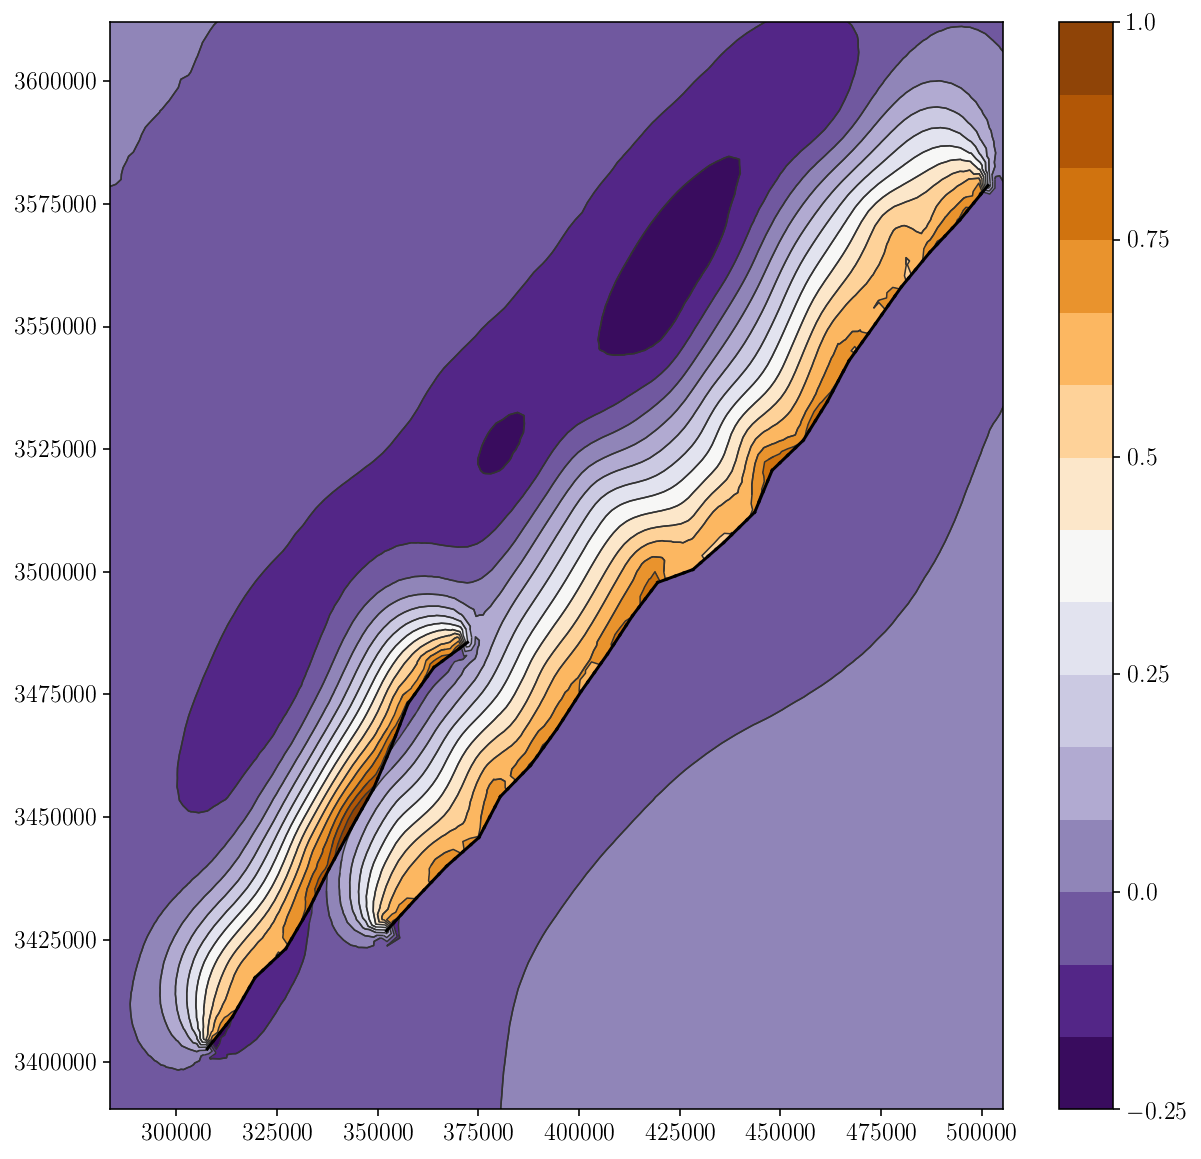

In [13]:
plt.figure(figsize = (10, 10))
field = soln.reshape((-1,3,3))[:fault_start_idx,:,d]
for i in range(2):
    which_tris = np.where(np.logical_or(side[:fault_start_idx] == 0, side[:fault_start_idx] == i + 1))[0]
    reduced_m = remove_unused_pts((m_pts, m_tris[which_tris]))
    soln_vals = np.empty(reduced_m[0].shape[0])
    soln_vals[reduced_m[1]] = field[which_tris]

    triang_ = tri.Triangulation(reduced_m[0][:,0], reduced_m[0][:,1], triangles = reduced_m[1])
    tri_refi, interp_vals = triang_, soln_vals
    cntf = plt.tricontourf(tri_refi, interp_vals, cmap = cmap, levels = levels)
    plt.tricontour(
        tri_refi, interp_vals, levels = levels, 
        colors = '#333333', linestyles = 'solid', linewidths = 0.75
    )

for e in surf_fault_edges:
    i1, d1 = e[0]
    i2, d2 = e[1]
    pts = m_pts[[m_tris[fault_start_idx:][i1,d1], m_tris[fault_start_idx:][i2,d2]]]
    plt.plot(pts[:,0], pts[:,1], 'k-', markersize = 10)

cbar = plt.colorbar(cntf)
cbar.set_ticks(levels[::3])
cbar.set_ticklabels(['$' + str(l) + '$' for l in levels[::3]])
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.savefig('tectosaur.pdf')
plt.show()